In [1]:
# root_content = open ('root_content.txt', encoding='gb18030')
# lines = root_content.readlines()
f = open('root_content.txt', encoding='utf-8')

看一下数据

root_content 中的数据格式为：

- 单数行是源微博的索引
- 双数行是对应源微博的内容

In [2]:
weibo_index = f.readline()
print(weibo_index)
weibo_content = f.readline()
print(weibo_content)

3515638699605834

当前后左右都没有路时，命运一定是鼓励你向上飞了。



导入BERT相关模型

In [3]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

加载预训练中文模型及其tokenizer

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('./bert-base-chinese')

以上面那句话为例转化为Sentence Embedding，主要经历一下几个步骤
- 给句首和句尾分别加 “[cls]” 和 “[sep]” 标识
- 将原语句进行分词处理（tokenize）
- 将分词后的语句从词语转化为编号
- 给语句添加全1标识（因为此处我们考虑是单句）
- 通过 BERT 预训练模型得到每一个词的 embedding （一共有 词数 * 12 * 768 个变量）
- 生成句向量 （根据 “... a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector ...”）


In [5]:
weibo_content = '[cls]' + weibo_content + '[sep]'   # step 1
tokenized_weibo_content = tokenizer.tokenize(weibo_content) # step 2
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_weibo_content)   # step 3
segments_ids = [1] * len(tokenized_weibo_content)   # step 4

tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])


In [6]:
model.eval()

with torch.no_grad():   # step 5
    encoded_layers, _ = model(tokens_tensor, segments_tensors)
    token_embeddings = torch.stack(encoded_layers, dim=0)

print(token_embeddings.shape)

torch.Size([12, 1, 31, 768])


12个隐层，batch size = 1（一个句子），31个token， 768维向量

In [7]:
token_vecs = encoded_layers[-1][0]
sentence_embedding = torch.mean(token_vecs, dim=0)
print(sentence_embedding.shape)


torch.Size([768])


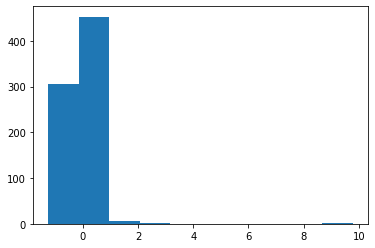

In [9]:
import matplotlib.pyplot as plt

plt.hist(sentence_embedding)
plt.show()

In [10]:
f.close()

In [12]:
sentence_embedding = sentence_embedding.unsqueeze(0)
a = torch.zeros_like(sentence_embedding)
b = torch.cat((sentence_embedding, a), dim=0)
print(b.shape)

torch.Size([2, 768])


In [13]:
print(b[1])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

以下为宇菲的原始notebook

In [23]:
i = 0
contents = []
for line in lines:
    line = line.strip('\n')
    if i % 2 == 1 and line != '' and  line != ' ':
        contents.append(line)
    i += 1

In [24]:
len(contents)

299994

In [13]:
from bert_serving.client import BertClient
import numpy as np

In [27]:
bc = BertClient()

In [28]:
bert_embeddings0 = bc.encode(contents[:1000])

In [34]:
bert_embeddings1 = bc.encode(contents[1000:2000])

In [36]:
bert_embeddings0

array([[ 1.16279304e+00, -8.78091902e-02,  1.62150070e-01, ...,
         6.89635515e-01, -1.42186195e-01, -5.93151450e-01],
       [ 5.36077440e-01,  1.58715397e-02,  6.96792975e-02, ...,
         1.07420951e-01,  4.36760604e-01, -2.52175182e-01],
       [ 9.78850484e-01,  7.07786307e-02, -1.18462920e-01, ...,
         2.70790219e-01, -2.74992317e-01, -2.27317885e-01],
       ...,
       [ 1.01003492e+00,  1.29530951e-01,  1.12249345e-01, ...,
         2.01806709e-01,  3.90352726e-01, -2.20788121e-01],
       [ 4.06087935e-01,  6.58302102e-04, -1.36833340e-01, ...,
         1.05722487e-01,  4.60192591e-01, -3.80214155e-01],
       [ 4.53770012e-01,  9.73000824e-02,  7.20527619e-02, ...,
         5.09672761e-01,  3.44118685e-01, -3.33973706e-01]], dtype=float32)

In [42]:
bert_embeddings =  np.concatenate((bert_embeddings0, bert_embeddings1), axis=0)

In [35]:
bert_embeddings0 = bert_embeddings

In [30]:
from sklearn.cluster import KMeans

In [49]:
n_clusters=10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(bert_embeddings)

In [50]:
for target in range(n_clusters):
    wf = open (str(target)+'.txt','w', encoding = 'utf-8')
    for sentence, label in zip(contents[:2000],kmeans.labels_):     
        if label == target:
            wf.write(sentence)
            wf.write('\n')
    wf.close()